<a href="https://colab.research.google.com/github/SaraKarim23/COVID-19_Severity_Classification_/blob/main/COVID_19_Severity_Classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Drive Mount


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Tensorflow and Keras


In [4]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Data Directory

In [6]:
import os
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/drive/My Drive/Colab Notebooks/dataset_test'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test') 

# Initialization

In [7]:
image_size = (224, 224) # efficienetB0/VGG16/VGG19/ResNet18,50,152/DenseNet121/InceptionV3/...
#image_size = (240, 240) # efficienetB1
#image_size = (260, 260) # efficienetB2
#image_size = (300, 300) # efficienetB3
#image_size = (380, 380) # efficienetB4
#image_size = (456, 456) # efficienetB5

#batch_size = 32
#batch_size = 16
#batch_size = 12
#batch_size = 10
#batch_size = 8
batch_size = 6
#batch_size = 1

LEARNING_RATE=0.0001
#LEARNING_RATE=0.001
#LEARNING_RATE=0.01

#num_classes=2
num_classes=3
#num_classes=4

epochs = 2
#epochs = 5
#epochs = 10
#epochs = 20
#epochs = 30
#epochs = 40
#epochs = 50

#Training, Validation and Testing data load. Train and Validation Augmentation.**bold text**

In [8]:
trdata=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.10,
    zoom_range=0.10,
    fill_mode="nearest",
    horizontal_flip=True,
    validation_split=0.1
)

train_ds = trdata.flow_from_directory(
    directory=train_dir,
    target_size=image_size,
    class_mode="categorical",
    subset="training",
    batch_size=batch_size,
    shuffle=True,
)

valdata=tf.keras.preprocessing.image.ImageDataGenerator()

val_ds = trdata.flow_from_directory(
    directory=train_dir,
    target_size=image_size,
    class_mode="categorical",
    subset="validation",
    batch_size=batch_size,
)

testdata=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_ds = testdata.flow_from_directory(
    directory=test_dir,
    target_size=image_size,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
)


Found 33 images belonging to 3 classes.
Found 3 images belonging to 3 classes.
Found 18 images belonging to 3 classes.


# Training, Validation and Testing data load. Train and Validation Without Augmentation.

In [9]:
trdata=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.1  
)

train_ds = trdata.flow_from_directory(
    directory=train_dir,
    target_size=image_size,
    class_mode="categorical",
    subset="training",
    batch_size=batch_size,
    shuffle=True,
)

valdata=tf.keras.preprocessing.image.ImageDataGenerator()

val_ds = trdata.flow_from_directory(
    directory=train_dir,
    target_size=image_size,
    class_mode="categorical",
    subset="validation",
    batch_size=batch_size,
)

testdata=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_ds = testdata.flow_from_directory(
    directory=test_dir,
    target_size=image_size,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
)

Found 33 images belonging to 3 classes.
Found 3 images belonging to 3 classes.
Found 18 images belonging to 3 classes.


# **Class Weight**

In [10]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_ds.classes), 
                train_ds.classes)

print(class_weights)
print(train_ds.class_indices)

[1. 1. 1.]
{'COVID-19': 0, 'NORMAL': 1, 'Viral Pneumonia': 2}


# Efficientnet Installation




In [11]:
!pip install -U git+https://github.com/qubvel/efficientnet

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-h5adip8h
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-h5adip8h
  Created wheel for efficientnet: filename=efficientnet-1.1.1-cp36-none-any.whl size=18422 sha256=1a0255576a75f305c390b8a1fb6ddaff85cd3048c5ff53c893455b400afb181e
  Stored in directory: /tmp/pip-ephem-wheel-cache-_aijnmq4/wheels/64/60/2e/30ebaa76ed1626e86bfb0cc0579b737fdb7d9ff8cb9522663a
Successfully built efficientnet
  Found existing installation: efficientnet 1.1.1
    Uninstalling efficientnet-1.1.1:
      Successfully uninstalled efficientnet-1.1.1


# **Swish Activation**

In [12]:
from keras.backend import sigmoid
from keras.utils import get_custom_objects
from keras.layers import Activation

class SwishActivation(Activation):
    
    def __init__(self, activation, **kwargs):
        super(SwishActivation, self).__init__(activation, **kwargs)
        self.__name__ = 'swish_act'

def swish_act(x, beta = 1):
    return (x * sigmoid(beta * x))


get_custom_objects().update({'swish_act': SwishActivation(swish_act)})

# **Model Build (EfficientNet (B0-B5)+ImageNet Weight+ Custom Classifier Layer)**

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
____________________________________________________________________________________________

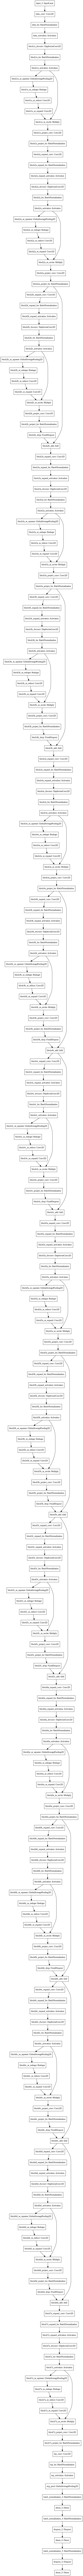

In [14]:
from keras import layers
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D,ZeroPadding2D
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.applications import DenseNet121
from keras.applications import MobileNetV2
from keras.regularizers import l2
from keras.utils import plot_model

from keras import optimizers
import efficientnet.tfkeras as enet

base_model = enet.EfficientNetB0(include_top=False, input_shape=(224,224,3), pooling='avg', weights="imagenet",classes=num_classes)
#base_model = enet.EfficientNetB1(include_top=False, input_shape=(240,240,3), pooling='avg', wei="imagenet",classghtses=num_classes)
#base_model = enet.EfficientNetB2(include_top=False, input_shape=(260,260,3), pooling='avg', weights="imagenet",classes=num_classes)
#base_model = enet.EfficientNetB3(include_top=False, input_shape=(300,300,3), pooling='avg', weights="imagenet", classes=num_classes)
#base_model = enet.EfficientNetB4(include_top=False, input_shape=(380,380,3), pooling='avg', weights="imagenet", classes=num_classes)
#base_model = enet.EfficientNetB5(include_top=False, input_shape=(456,456,3), pooling='avg', weights="imagenet", classes=num_classes)


x = base_model.output
x = BatchNormalization()(x)

# Classification Start(ANN)

x = Dense(512,kernel_regularizer=l2(0.001),activation='sigmoid')(x)
x = BatchNormalization()(x)
#x = Activation(swish_act)(x)
x = Dropout(0.3)(x)

x = Dense(512,kernel_regularizer=l2(0.001),activation='sigmoid')(x)
x = BatchNormalization()(x)
#x = Activation(swish_act)(x) 
x = Dropout(0.3)(x)

# Output layer
predictions = Dense(num_classes, activation="softmax")(x)

model= Model(inputs = base_model.input, outputs = predictions)

model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=LEARNING_RATE),metrics=['acc'])

model.summary()
model.save('/content/drive/My Drive/Colab Notebooks/COVID-19 Severity Models/model_base.h5')
plot_model(model)

# **Model Build(VGG/ResNet/Inception/DenseNet + Without ImageNet Weight+Original Classifier Layer)**

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization_6[0][0]      
_______________________________________________________________________________________

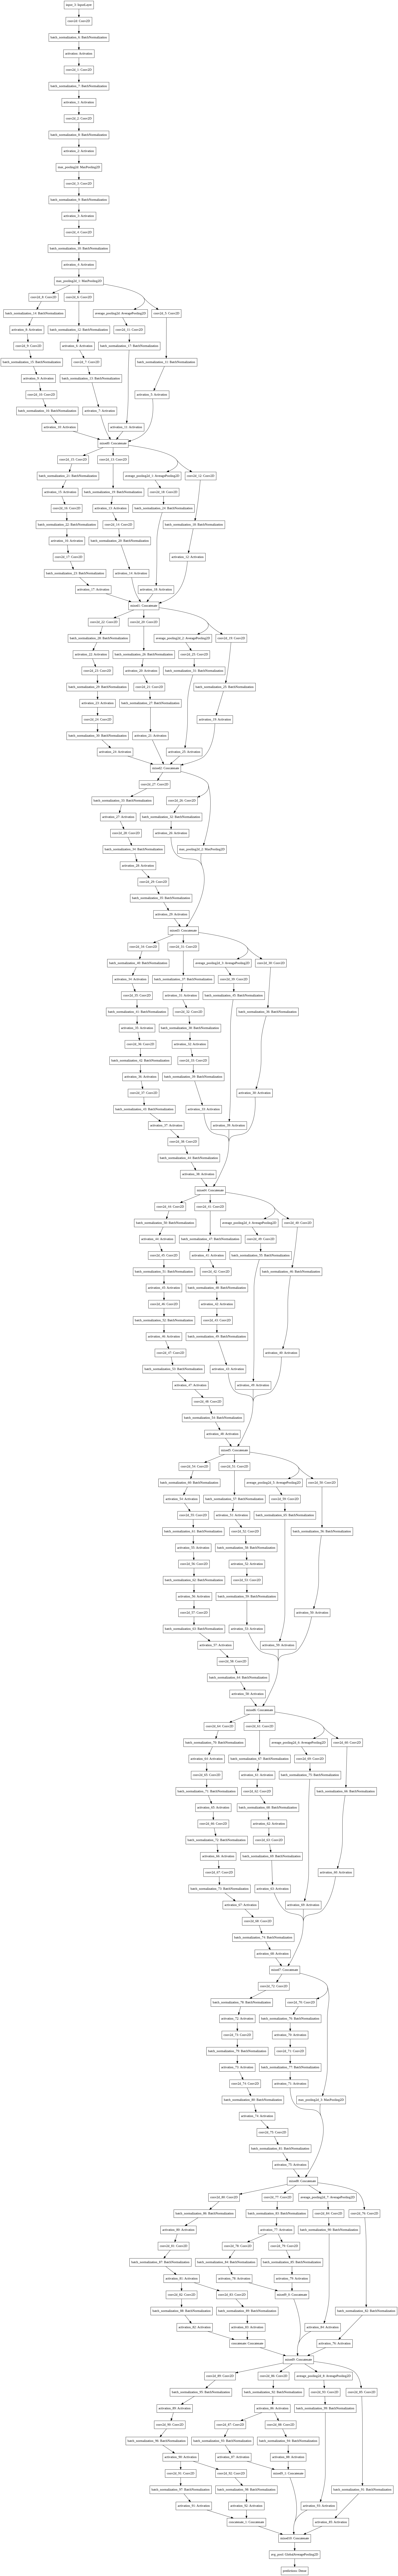

In [15]:
from keras import models
from keras import layers
from keras import applications
from keras.applications import VGG16, VGG19
from keras.applications import DenseNet121
from keras.applications import InceptionV3
from keras.applications import ResNet50,ResNet152
from keras import optimizers
from keras.regularizers import l2
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras import backend as K

#model=VGG16(include_top=True, weights=None, input_shape=(224, 224, 3),pooling=max,classes=num_classes)
#model=VGG19(include_top=True, weights=None, input_shape=(224, 224, 3),pooling=max,classes=num_classes)
model=InceptionV3(include_top=True, weights=None, input_shape=(224, 224, 3),pooling=max,classes=num_classes)
#model=DenseNet121(include_top=True, weights=None, input_shape=(224, 224, 3),pooling=max,classes=num_classes)
#model=ResNet50(include_top=True, weights=None, input_shape=(224, 224, 3), pooling=max, classes=num_classes)
#model=ResNet152(include_top=True, weights=None, input_shape=(224, 224, 3), pooling=max, classes=num_classes)

model.trainable = True

model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=LEARNING_RATE),metrics=['acc'])
model.summary()
model.save('/content/drive/My Drive/Colab Notebooks/COVID-19 Severity Models/model_base.h5')
plot_model(model)

# **Model Build(VGG/ResNet/Inception/DenseNet + ImageNet Weight+Custom Classifier Layer)**

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_100 (BatchN (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_100[0][0]    
____________________________________________________________________________________________

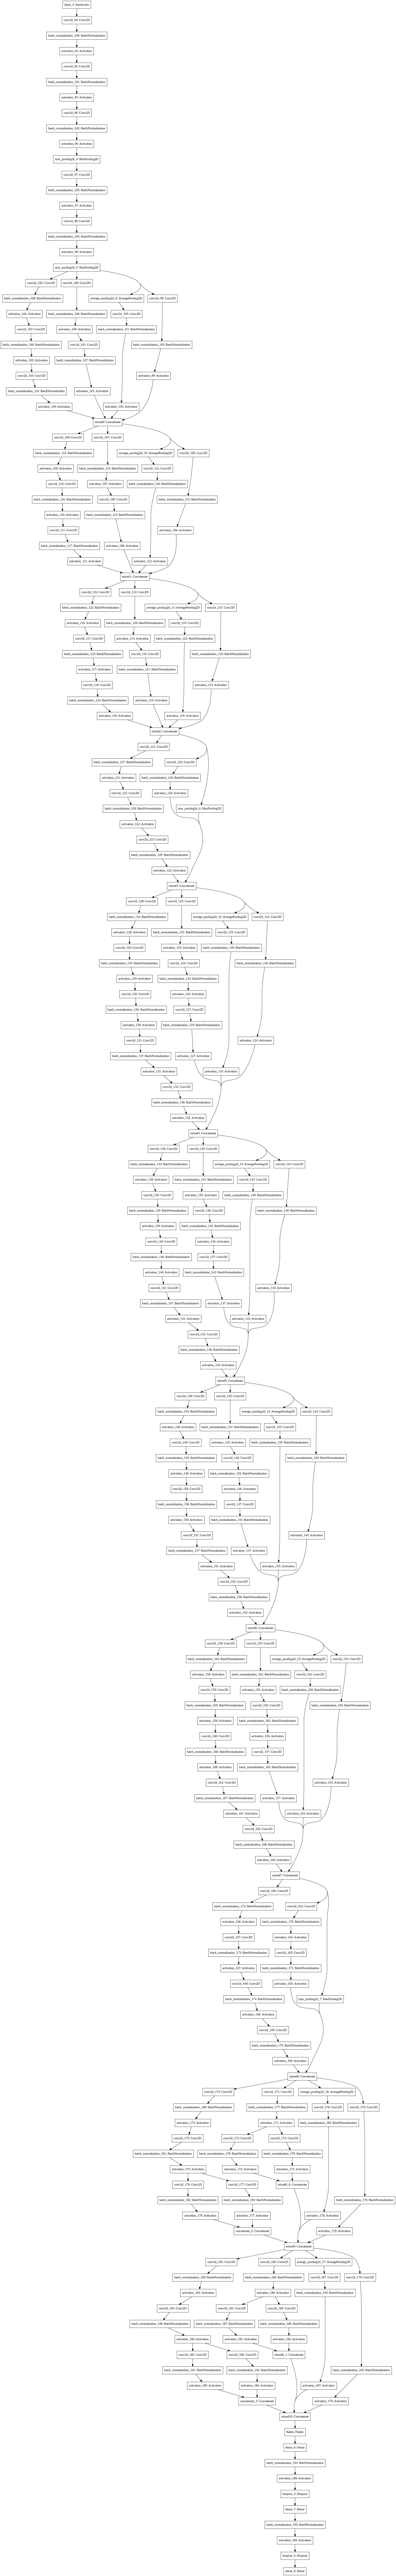

In [16]:
from keras import models
from keras import layers
from keras import applications
from keras.applications import VGG16, VGG19
from keras.applications import DenseNet121
from keras.applications import InceptionV3
from keras.applications import ResNet50,ResNet152
from keras import optimizers
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from keras.utils import plot_model

#base_model=VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3),pooling=max,classes=num_classes)
#base_model=VGG19(include_top=False, weights="imagenet", input_shape=(224, 224, 3),pooling=max,classes=num_classes)
base_model=InceptionV3(include_top=False, weights="imagenet", input_shape=(224, 224, 3),pooling=max,classes=num_classes)
#base_model=DenseNet121(include_top=False, weights="imagenet", input_shape=(224, 224, 3),pooling=max,classes=num_classes)
#base_model=ResNet50(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling=max, classes=num_classes)
#base_model=ResNet152(include_top=False, weights="imagenet", input_shape=(224, 224, 3), pooling=max, classes=num_classes)

base_model.trainable = False

x = base_model.output
x = Flatten()(x)

# Classification Start(ANN)

x = Dense(512,kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x)
x = Dropout(0.3)(x)

x = Dense(512,kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation(swish_act)(x) 
x = Dropout(0.3)(x)

# Output layer
predictions = Dense(num_classes, activation="softmax")(x)

model= Model(inputs = base_model.input, outputs = predictions)

model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=LEARNING_RATE),metrics=['acc'])
model.summary()
model.save('/content/drive/My Drive/Colab Notebooks/COVID-19 Severity Models/model_base.h5')
plot_model(model)

# Model Fit

In [17]:
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

checkpoint = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/COVID-19 Severity Models/model_weight.h5', monitor='val_acc',save_best_only=True,)
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=20, verbose=1, mode='auto')

history=model.fit(
    train_ds, epochs=epochs, callbacks=[checkpoint,early], validation_data=val_ds
)

Epoch 1/2
6/6 [==============================] - 9s 423ms/step - loss: 2.5104 - acc: 0.4892 - val_loss: 2.1504 - val_acc: 0.6667
Epoch 2/2
6/6 [==============================] - 1s 149ms/step - loss: 1.9835 - acc: 0.8522 - val_loss: 2.1645 - val_acc: 0.6667


# **Loss Curve**

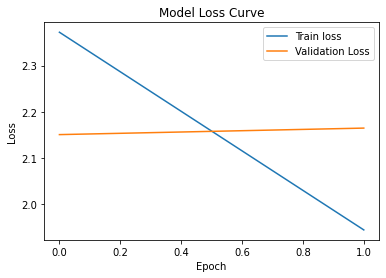

In [18]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss Curve")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train loss","Validation Loss"])
plt.show()
fig.savefig('/content/drive/My Drive/Colab Notebooks/COVID-19 Severity Models/epoch vs loss curve.jpg')

# **Accuracy Curve**

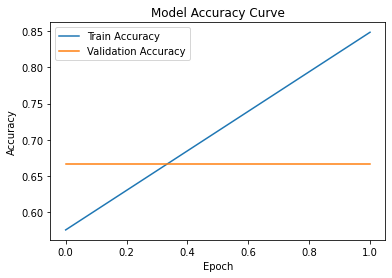

In [19]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title("Model Accuracy Curve")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train Accuracy","Validation Accuracy"])
plt.show()
fig.savefig('/content/drive/My Drive/Colab Notebooks/COVID-19 Severity Models/epoch vs accuracy curve.jpg')

# **Confusion Matrix**

Confusion matrix, without normalization
[[3 1 2]
 [0 6 0]
 [0 0 6]]


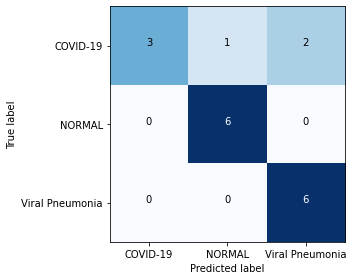

                 precision    recall  f1-score   support

       COVID-19     1.0000    0.5000    0.6667         6
         NORMAL     0.8571    1.0000    0.9231         6
Viral Pneumonia     0.7500    1.0000    0.8571         6

       accuracy                         0.8333        18
      macro avg     0.8690    0.8333    0.8156        18
   weighted avg     0.8690    0.8333    0.8156        18



In [20]:
import matplotlib.pyplot as plt
import sklearn
from itertools import product
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from keras.models import load_model
#from keras.weights import load_weights
import efficientnet.tfkeras
from tensorflow.keras.models import load_model

model= load_model('/content/drive/My Drive/Colab Notebooks/COVID-19 Severity Models/model_base.h5')
model.load_weights('/content/drive/My Drive/Colab Notebooks/COVID-19 Severity Models/model_weight.h5')


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes, rotation=0)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
      for j in range (cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/content/drive/My Drive/Colab Notebooks/COVID-19 Severity Models/confusion_matrix.jpg')


class_labels = test_ds.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confution Matrix and Classification Report

Y_pred = model.predict(test_ds) 
y_pred = np.argmax(Y_pred, axis=1)
target_names = list(class_labels.values())
predicted_classes = np.argmax(Y_pred, axis=1)

# Generate the confusion matrix
cnf_matrix = confusion_matrix(test_ds.classes, y_pred) 

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classes,
                      title='')

plt.show()

print(classification_report(test_ds.classes, y_pred, target_names=target_names,digits=4))